# Processing GPU data with Python Operators

This example shows how to use `PythonFunction` Operator on GPU. For an introduction and general information about Python Operators family see the [Python Operators](./python_operator.ipynb) notebook.

Although Python Operators are not designed to be fast, it still might be useful to run them on GPU, for example, when we want to introduce a custom operation into an existing GPU pipeline. For this purpose, all Operators in the `PythonFunction` family have their GPU variants. In `TorchPythonFunction` and `DLTensorPythonFunction` data format on which they operate stays the same as for CPU - PyTorch tensors in the first one and [DLPack](https://github.com/dmlc/dlpack) tensors in the latter. In case of GPU `PythonFunction`, inputs and outputs of the implementation function are [CuPy](https://cupy.chainer.org/) arrays.

## CuPy operations
Since *CuPy* arrays API is similar to the one seen in NumPy, we can implement the same operation as we defined in the CPU example almost without any code changes. 

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy 
import cupy 

def edit_images(image1, image2):
    assert image1.shape == image2.shape
    h, w, c = image1.shape
    y, x = cupy.ogrid[0:h, 0:w]
    mask = (x - w / 2) ** 2 + (y - h / 2) ** 2 > h * w / 9
    result1 = cupy.copy(image1)
    result1[mask] = image2[mask]
    result2 = cupy.copy(image2)
    result2[mask] = image1[mask]
    return result1, result2



Another way to define a GPU function with *CuPy* is writing a CUDA kernel. Below we present a simple kernel interleaving channels of two images. More information about that topic can be found in the *CuPy* [documentation](https://docs-cupy.chainer.org/en/stable/tutorial/kernel.html).

In [2]:
mix_channels_kernel = cupy.ElementwiseKernel(
        'uint8 x, uint8 y',
        'uint8 z',
        'z = (i % 3) ? x : y',
        'mix_channels'
    )

## Defining a pipeline
We define a pipeline similar to that used in the [Python Operators](./python_operator.ipynb) notebook. We only change Operators' devices to move the execution from CPU to GPU. It is also the only difference in declaration of the `PythonFunction` Operators. 

In [3]:

image_dir = '../data/images'

class CommonPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super(CommonPipeline, self).__init__(batch_size, num_threads, device_id, exec_async=False,
                                             exec_pipelined=False, seed=99)
        self.input1 = ops.FileReader(file_root=image_dir, random_shuffle=True)
        self.input2 = ops.FileReader(file_root=image_dir, random_shuffle=True)
        self.decode = ops.ImageDecoder(device='mixed', output_type=types.RGB)
        self.resize = ops.Resize(resize_x=300, resize_y=300, device='gpu')
        
    def load(self):
        jpegs1, labels = self.input1()
        jpegs2, labels = self.input2()
        im1, im2 = self.decode([jpegs1, jpegs2])
        return self.resize([im1, im2])
        

class PythonFuncPipeline(CommonPipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super(PythonFuncPipeline, self).__init__(batch_size, num_threads, device_id, image_dir)
        self.edit_images = ops.PythonFunction(function=edit_images, num_outputs=2, device='gpu')
        self.mix = ops.PythonFunction(function=mix_channels_kernel, device='gpu')

    def define_graph(self):
        images1, images2 = self.load()
        res1, res2 = self.edit_images(images1, images2)
        res3 = self.mix(images1, images2)
        return res1, res2, res3

## Running the pipeline and visualizing the results
We can run the pipeline and show the results the way we know from the CPU example. We only have to remember to move the output batches to host memory before trying to plot them.

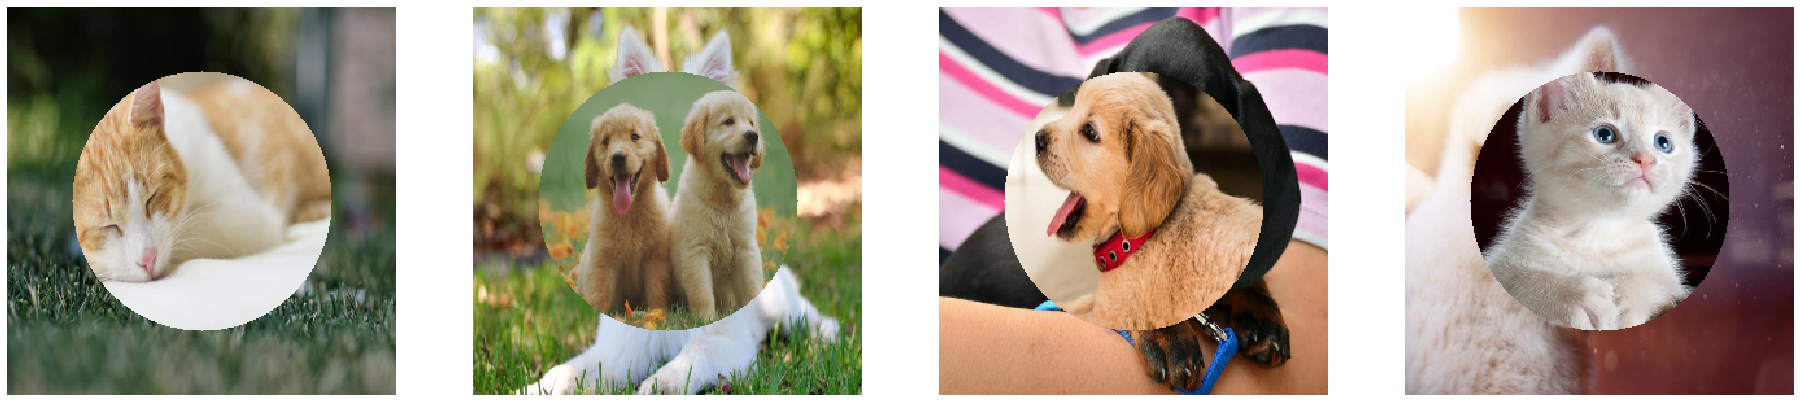

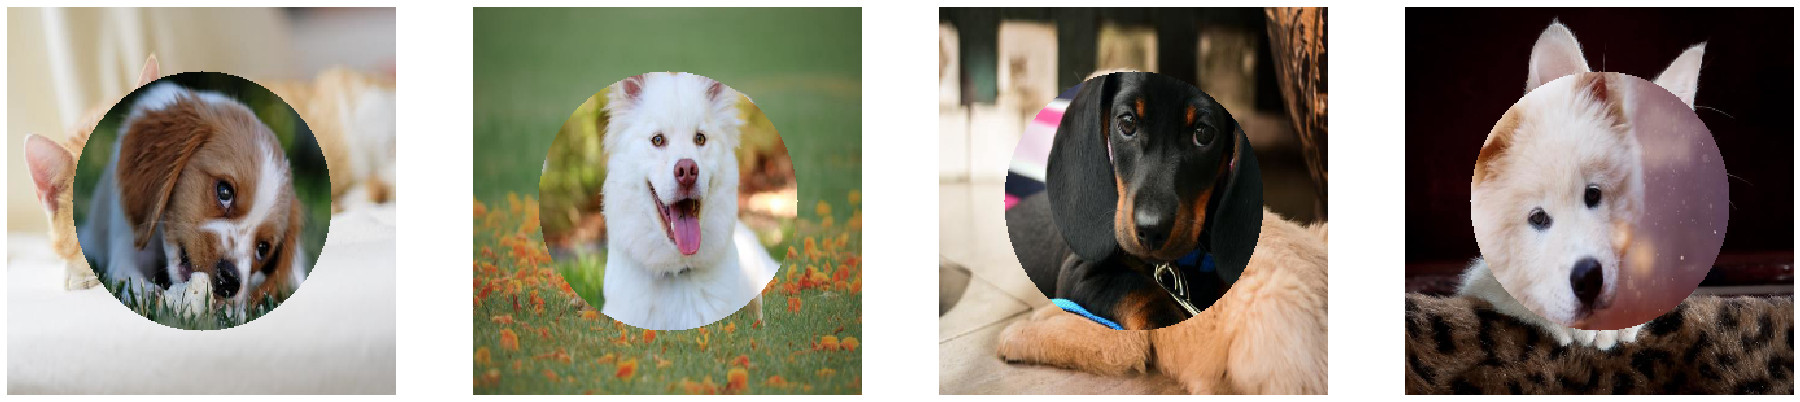

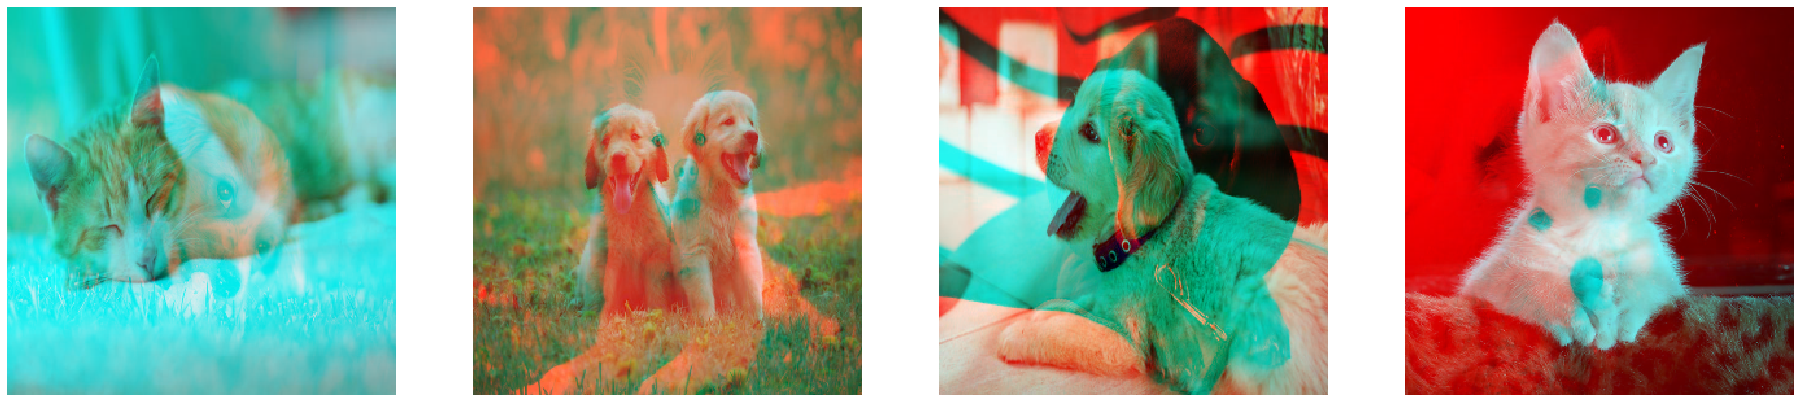

In [4]:

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
%matplotlib inline

batch_size = 4

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))


pipe = PythonFuncPipeline(batch_size, 4, 0, image_dir)
pipe.build()
ims1, ims2, ims3 = pipe.run()

show_images(ims1.as_cpu())
show_images(ims2.as_cpu())
show_images(ims3.as_cpu())

## Advanced: device synchronization in DLTensorPythonFunction
When using `PythonFunction` or `TorchPythonFunction` we do not have to bother about synchronizing our GPU code with the rest of DALI pipeline, becuase it is handled by the Operator. The `DLTensorPythonFunction` Operator, on the other hand, works on a lower level and leaves the device synchronization to the user. The particular way of doing this may vary for different frameworks and libraries. As an example we will write a wrapper around previously implemented `mix_channels_kernel` that converts DLPack tensors to *CuPy* arrays and handles the stream synchronization. 


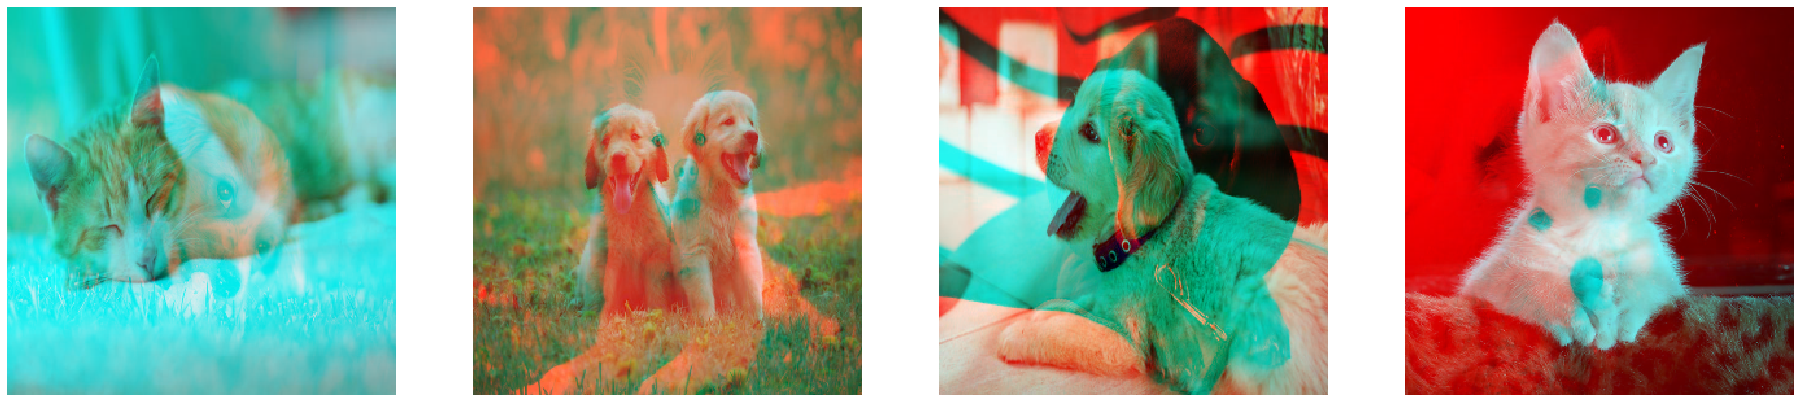

In [5]:
def mix_channels_wrapper(tensor1, tensor2):
    array1 = cupy.fromDlpack(tensor1)
    array2 = cupy.fromDlpack(tensor2)
    result = mix_channels_kernel(array1, array2)
    cupy.cuda.get_current_stream().synchronize()
    return result.toDlpack()

class DLTensorPythonFuncPipeline(CommonPipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super(DLTensorPythonFuncPipeline, self).__init__(batch_size, num_threads, device_id, image_dir)
        self.mix = ops.DLTensorPythonFunction(function=mix_channels_wrapper, device='gpu', 
                                              synchronize_stream=True, batch_processing=False)

    def define_graph(self):
        images1, images2 = self.load()
        res = self.mix(images1, images2)
        return res

pipe = DLTensorPythonFuncPipeline(batch_size, 4, 0, image_dir)
pipe.build()
ims, = pipe.run()

show_images(ims.as_cpu())

As we can see, the result is the same as after running `mix_channels_kernel` inside `PythonFunction`. To properly synchronize device code in `DLTensorPythonFunction` we have to ensure that:

* all the preceding **DALI** GPU work is done before the start of a provided function, 
* the work we schedule inside finishes before we return the results. 

The first condition is warranted by the `synchronize_stream=True` flag (ON by default). User is responsible for providing the second part. In the example above it is achieved by adding the line `cupy.cuda.get_current_stream().synchronize()`.